**Before you start**<br>
Change runtime type to GPU <br>
Runtime > Change runtime type > GPU > Save

In [1]:
# this will download a zip file containing training data
!gdown --id 1NHloOEffC0TmmiKFDsfVKRek-kLkN2W0
# this will unzip the training data file
!unzip -qq /content/training\ data.zip
# go check it out in the folder view on the left

Downloading...
From: https://drive.google.com/uc?id=1NHloOEffC0TmmiKFDsfVKRek-kLkN2W0
To: /content/training data.zip
100% 175M/175M [00:01<00:00, 119MB/s]


In [2]:
# install fastai, this is a deep learning library
!pip install -Uqq fastbook
from fastai.vision.all import *
# this will make sure plots are printed as expected
%matplotlib inline  


     |████████████████████████████████| 720 kB 5.3 MB/s 
     |████████████████████████████████| 189 kB 39.4 MB/s 
     |████████████████████████████████| 46 kB 4.2 MB/s 
     |████████████████████████████████| 1.2 MB 32.8 MB/s 
     |████████████████████████████████| 56 kB 4.3 MB/s 
     |████████████████████████████████| 51 kB 317 kB/s 


In [3]:
# point the script at the data
path = Path('/content/training data')
path

Path('/content/training data')

In [4]:
# define model name
model_name = 'cloud_model'

In [5]:
# make sure things look correct
path.ls()

(#4) [Path('/content/training data/cloud'),Path('/content/training data/models'),Path('/content/training data/no cloud'),Path('/content/training data/classes.csv')]

In [6]:
# set model settings
batch_size = 10
img_size = 100

In [7]:
# define image transforms
item_tfms = [Resize(img_size)]
batch_tfms = [Normalize.from_stats(*imagenet_stats),
            *aug_transforms(size=img_size, flip_vert=True,max_rotate=90.0,max_lighting=0.1,
                            min_zoom=0.8, max_zoom=1.3, max_warp=0,                             
                            )]


In [8]:
# load data
data = ImageDataLoaders.from_folder(path, train=".", valid_pct=0.2,splitter=RandomSplitter(seed=42),
                                    bs=batch_size,
                                    item_tfms=item_tfms,
                                    batch_tfms=batch_tfms
                                   )


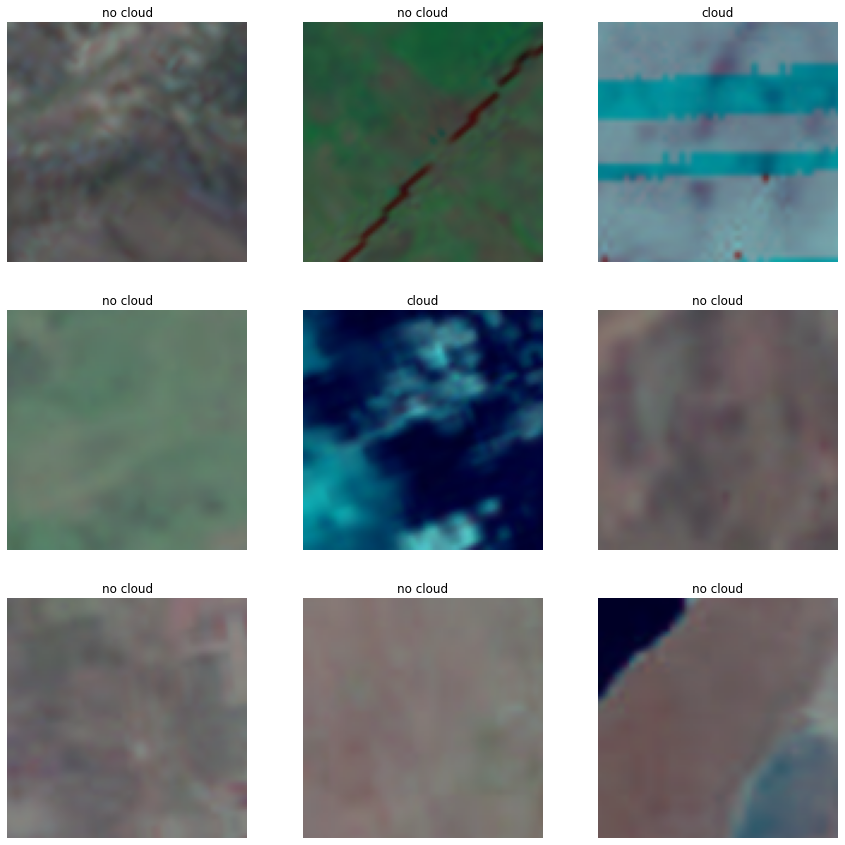

In [9]:
# check data
data.show_batch(max_n = 9, figsize = (15,15))

In [10]:
# save classes to txt file
np.savetxt(path/'classes.csv', np.array(data.vocab), fmt='%s')

In [11]:
# define the model
learn = cnn_learner(data, resnet18, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [12]:
learn.fine_tune?

Better model found at epoch 0 with valid_loss value: 0.19712600111961365.


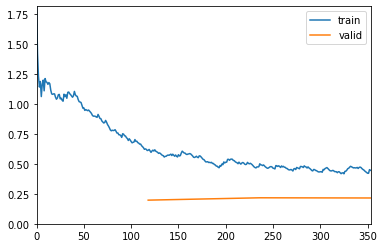

Better model found at epoch 0 with valid_loss value: 0.12461086362600327.


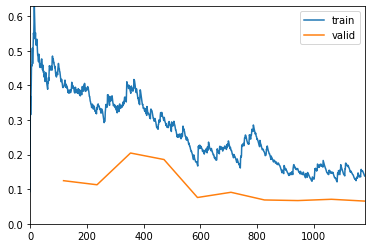

Better model found at epoch 1 with valid_loss value: 0.11282911896705627.
Better model found at epoch 4 with valid_loss value: 0.07599756866693497.
Better model found at epoch 6 with valid_loss value: 0.06889836490154266.
Better model found at epoch 7 with valid_loss value: 0.06715068221092224.
Better model found at epoch 9 with valid_loss value: 0.06560702621936798.


In [13]:
# train model
learn.fine_tune(10,freeze_epochs=3,cbs = [ShowGraphCallback(),
                         SaveModelCallback(monitor='valid_loss',with_opt=True, fname=model_name)])


In [14]:
# reload best model
learn.load(model_name)

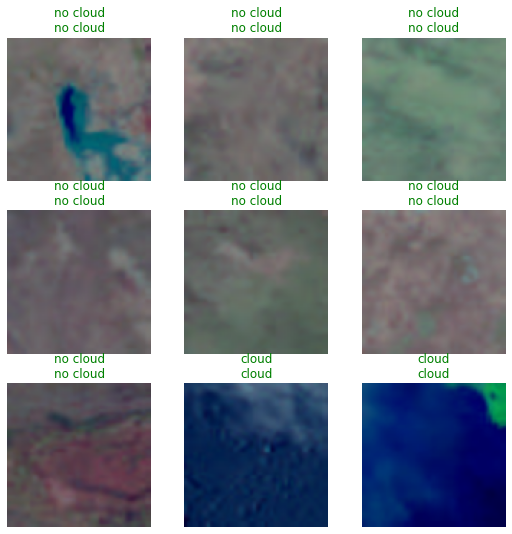

In [15]:
# check the outputs
learn.show_results()

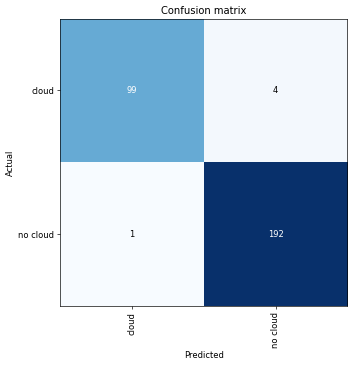

In [16]:
# check confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [17]:
# export model to disk
learn.export('models/'+model_name+'.pkl')

# Infernce

In [18]:
# install some GIS tools
!pip install geopandas
!pip install rasterio

     |████████████████████████████████| 1.0 MB 5.2 MB/s 
     |████████████████████████████████| 15.4 MB 41 kB/s 
     |████████████████████████████████| 6.3 MB 36.6 MB/s 
     |████████████████████████████████| 19.3 MB 7.4 MB/s 


In [19]:
import os
import rasterio
from tqdm.auto import tqdm
import geopandas as gpd
from shapely.geometry import box

In [20]:
# download geotiff to test model on
!gdown --id 1V2qP08exQT59CzISlJPixb4oPQY1N6jL

Downloading...
From: https://drive.google.com/uc?id=1V2qP08exQT59CzISlJPixb4oPQY1N6jL
To: /content/202005051350_NPP_VII_ALI_44149_721_clip.tif
100% 10.5M/10.5M [00:00<00:00, 64.0MB/s]


In [21]:
# point script at geotiff
raster_path = '/content/202005051350_NPP_VII_ALI_44149_721_clip.tif'
os.path.isfile(raster_path)

True

In [22]:
# make folder for tiles
output_tile_folder = os.path.splitext(raster_path)[0]+'_tiles'
Path(output_tile_folder).mkdir(parents=True, exist_ok=True)
output_tile_folder

'/content/202005051350_NPP_VII_ALI_44149_721_clip_tiles'

In [23]:
# set tile options
size = [50,50] #[x,y]
output_compression = 'JPEG'#'lZW'
output_format = 'GTiff'

In [24]:
# get metadata from geotiff
with rasterio.open(raster_path) as open_raster:
    input_meta = open_raster.meta
input_meta

{'count': 3,
 'crs': CRS.from_epsg(3857),
 'driver': 'GTiff',
 'dtype': 'uint8',
 'height': 1606,
 'nodata': 236.0,
 'transform': Affine(455.65406536697196, 0.0, 12624609.2728,
       0.0, -455.6808777708591, -2773780.642),
 'width': 2180}

In [25]:
# make a list of tile by looping over raster height and width
tiles = []
left = 0
tile_count = 0
while left < input_meta['width']:
    top=0
    while top < input_meta['height']:
        tile_count += 1
        name = 'part_'+str(tile_count)+'_'+os.path.basename(raster_path)
        export_path = os.path.join(output_tile_folder,name)
        
        tiles.append([left,top,export_path])
        top += size[1]
    left += size[0]
print(len(tiles))
tiles[0]

1452


[0,
 0,
 '/content/202005051350_NPP_VII_ALI_44149_721_clip_tiles/part_1_202005051350_NPP_VII_ALI_44149_721_clip.tif']

In [26]:
# open raster
with rasterio.open(raster_path) as src:
  # cut out tiles
  for tile in tqdm(tiles):
      win = rasterio.windows.Window(tile[0], tile[1], size[0], size[1])
      win_data = src.read(window=win)
      win_transform = src.window_transform(win)
      meta = src.meta
      meta['compress'] = output_compression
      meta['driver'] = output_format
      meta['transform'] = win_transform
      meta['width'] = win_data.shape[2]
      meta['height'] = win_data.shape[1]
      with rasterio.open(tile[2], 'w', **meta) as dst:
          dst.write(win_data)
      win_data = None

  0%|          | 0/1452 [00:00<?, ?it/s]

In [27]:
# define the output vector file
export_vector_path = output_tile_folder+'.gpkg'
export_vector_path

'/content/202005051350_NPP_VII_ALI_44149_721_clip_tiles.gpkg'

In [28]:
# read classes from text file
classes = np.loadtxt(path/'classes.csv',delimiter='\n', dtype=str)
classes

array(['cloud', 'no cloud'], dtype='<U8')

In [29]:
# find all tiles and grab the CRS of one of them
input_rasters = []

for root, dirs, files in os.walk(output_tile_folder):
    for file in files:
        if file.endswith('.tif'):
            input_rasters.append(os.path.join(root, file))

dataset = rasterio.open(input_rasters[0])
crs = dataset.crs
            
print('File count',len(input_rasters))
print('CRS',crs)

File count 1452
CRS EPSG:3857


In [30]:
# load model, setup data and push to GPU
learn_inf = load_learner(path/('models/'+model_name+'.pkl'))
learn_inf.dls.cuda()
dl = learn_inf.dls.test_dl(input_rasters,device='cuda',bs=batch_size)

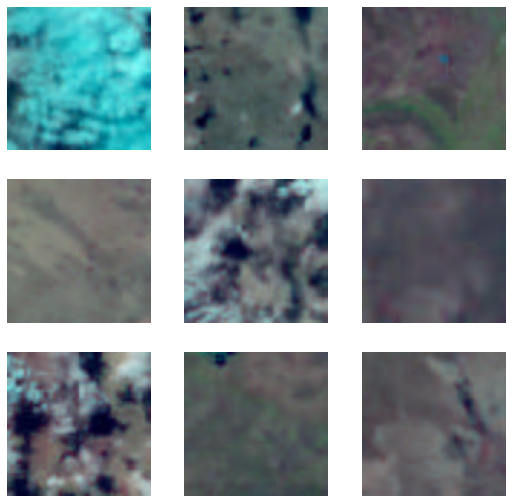

In [31]:
# display a batch
dl.show_batch()

In [32]:
# run model
pred_scores,none,pred_class_int = learn_inf.get_preds(dl=dl,with_decoded=True)

In [33]:
# have a look at the preds
pred_class_int

tensor([0, 0, 1,  ..., 0, 1, 0])

In [34]:
# use rasterio to open every raster and extract its extent
def get_bounds(raster):
    try:
        dataset = rasterio.open(raster)
        bounds = dataset.bounds
        geom = box(*bounds)
    except:
        print(raster)
    return geom

In [35]:
# set colours for visualization
colours = ['#0000FF','#FF0000']

In [36]:
# count tiles
len(input_rasters)

1452

In [37]:
# loop over data and save into list as dict
pred_dict_list = []
for pred_int,file_path,pred_score in tqdm(zip(pred_class_int,input_rasters,pred_scores.cpu().detach().numpy()),total=len(input_rasters)):
#     build dict for each image
    pred_dict = {'path':file_path,
                'pred_class':classes[pred_int],
                 'color' : colours[pred_int],
                 'geometry':get_bounds(file_path)
                 }
#     add number of class preds
    for class_name in classes:
        pred_index = list(classes).index(class_name)
        pred_dict[class_name] = pred_score[pred_index]

        
    pred_dict_list.append(pred_dict)

  0%|          | 0/1452 [00:00<?, ?it/s]

In [38]:
# build list of dicts into dataframe
preds_gdf = gpd.GeoDataFrame(pred_dict_list,crs=crs,geometry='geometry')

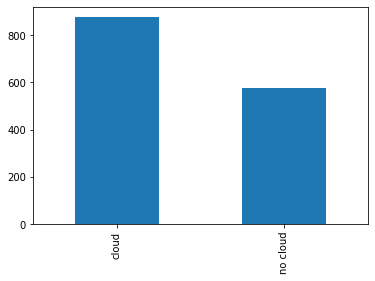

In [39]:
# plot distrobution
fig, ax = plt.subplots()
preds_gdf['pred_class'].value_counts().plot(ax=ax, kind='bar')

In [40]:
# export vector file
preds_gdf.to_file(export_vector_path, driver="GPKG")

In [41]:
# install folium
!pip install folium
import folium

In [42]:
# convert vector to 4326 and json
preds_gdf_json = preds_gdf.to_crs(epsg='4326').to_json()

In [43]:
# define vector style
def style(feature):
        return {
            'fillColor': feature['properties']['color'],
            'color': feature['properties']['color'],
            'weight': 1
        }

In [47]:
# plot vectors on map
mapa = folium.Map([-27,117.5],
                  zoom_start=7)

pred_polys = folium.features.GeoJson(preds_gdf_json,style_function=style)

mapa.add_child(pred_polys)
mapa

In [48]:
# download warped version of image
!gdown --id 1SYMsYoeRPrviV4gCS5c-DZqTIlVJWba-

Downloading...
From: https://drive.google.com/uc?id=1SYMsYoeRPrviV4gCS5c-DZqTIlVJWba-
To: /content/202005051350_NPP_VII_ALI_44149_721_clip_warp.tif
100% 10.5M/10.5M [00:00<00:00, 92.3MB/s]


In [49]:
# point script at warped tif
map_image = '/content/202005051350_NPP_VII_ALI_44149_721_clip_warp.tif'

In [50]:
# convert image to jpg
from PIL import Image

im = Image.open(map_image)
rgb_im = im.convert('RGB')
resample_img_name = 'Warp_JPG.jpg'

rgb_im.save(resample_img_name)

In [51]:
# extract image bounds
bounds = rasterio.open(map_image).bounds
bounds

BoundingBox(left=113.408794658, bottom=-30.015980333, right=122.331992702, top=-24.167078773)

In [52]:
# rearrange bounds
image_bounds = [[bounds.top,bounds.left],[bounds.bottom,bounds.right]]
image_bounds

[[-24.167078773, 113.408794658], [-30.015980333, 122.331992702]]

In [53]:
# plot map with vector and raster data
map = folium.Map([-27,117.5],
                  zoom_start=7)

folium.raster_layers.ImageOverlay(
    image=resample_img_name,
    bounds=image_bounds,
).add_to(map)

pred_polys = folium.features.GeoJson(preds_gdf_json,style_function=style)

map.add_child(pred_polys)
map